In this notebook we will run an _inference_ of the network trained in the [training example](http://deeplearnphysics.org/Blog/tutorial05-classification-training.html). For data sample we use the same sample used to test the network during the training (`practice_test_10k.root` can be found at our [public dataset](http://deeplearnphysics.org/DataChallenge)). For the setup of this example, we need to prepare `practice_test_10k.root` in the current directory. Let us make symbolic links.

In [1]:
%%bash
# Preparation: make symbolic links for practice_test_5k.root
PRACTICE_FILE_DIR=../../
ln -sf $PRACTICE_FILE_DIR/practice_test_5k.root ./test.root

We will use the network's weights from the previous training available under `weights` directory.

In [2]:
%%bash
ls weights/toynet-4999*

weights/toynet-4999.data-00000-of-00001
weights/toynet-4999.index
weights/toynet-4999.meta


## Imports

In [4]:
from __future__ import print_function
from larcv import larcv
from larcv.dataloader2 import larcv_threadio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os,sys,time

# tensorflow/gpu start-up configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2
import tensorflow as tf

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


## Configurations

In [5]:
TUTORIAL_DIR = '..'
IO_CONFIG    = os.path.join(TUTORIAL_DIR, 'tf/io_inference.cfg')
BATCH_SIZE   = 250
NUM_CLASS    = 5
SNAPSHOT     = "weights/toynet-4999"

A lot simpler since we aren't training and not saving logs therefore. But here's a reminder list of what these are.
* `TUTORIAL_DIR` ... points to the top-level directory of the [larcv-tutorial](https://github.com/DeepLearnPhysics/larcv-tutorial) repostitory.
* `IO_CONFIG` ... a configuration file for `larcv_threadio` to read data for testing.
* `BATCH_SIZE` ... a number of images to be loaded in 1 batch.
* `NUM_CLASS` ... a number of classification categories.

## Configure data reader
Again simpler compared to the training phase. We just need 1 data reader interface.

In [6]:
#
# Step 0: IO
#
# for "test" data set
test_io = larcv_threadio()   # create io interface
test_io_cfg = {'filler_name' : 'TestIO',
               'verbosity'   : 0,
               'filler_cfg'  : IO_CONFIG}
test_io.configure(test_io_cfg)   # configure
test_io.start_manager(BATCH_SIZE) # start read thread
time.sleep(2)
# Now we load 1st batch of data. Unlike in the training, enable the flags to store "entry ID" keys.
test_io.next(store_entries=True,store_event_ids=True)

 setting verbosity 3


## Definine a network
We use the exact same definition as the training notebook!

In [7]:
#
# Step 1: Define network
#
import tensorflow.contrib.slim as slim
import tensorflow.python.platform

def build(input_tensor, num_class=4, trainable=True, debug=True):

    net = input_tensor
    if debug: print('input tensor:', input_tensor.shape)

    filters = 32
    num_modules = 5
    with tf.variable_scope('conv'):
        for step in xrange(5):
            stride = 2
            if step: stride = 1
            net = slim.conv2d(inputs        = net,        # input tensor
                              num_outputs   = filters,    # number of filters (neurons) = # of output feature maps
                              kernel_size   = [3,3],      # kernel size
                              stride        = stride,     # stride size
                              trainable     = trainable,  # train or inference
                              activation_fn = tf.nn.relu, # relu
                              scope         = 'conv%da_conv' % step)

            net = slim.conv2d(inputs        = net,        # input tensor
                              num_outputs   = filters,    # number of filters (neurons) = # of output feature maps
                              kernel_size   = [3,3],      # kernel size
                              stride        = 1,          # stride size
                              trainable     = trainable,  # train or inference
                              activation_fn = tf.nn.relu, # relu
                              scope         = 'conv%db_conv' % step)
            if (step+1) < num_modules:
                net = slim.max_pool2d(inputs      = net,    # input tensor
                                      kernel_size = [2,2],  # kernel size
                                      stride      = 2,      # stride size
                                      scope       = 'conv%d_pool' % step)

            else:
                net = tf.layers.average_pooling2d(inputs = net,
                                                  pool_size = [net.get_shape()[-2].value,net.get_shape()[-3].value],
                                                  strides = 1,
                                                  padding = 'valid',
                                                  name = 'conv%d_pool' % step)
            filters *= 2

            if debug: print('After step',step,'shape',net.shape)

    with tf.variable_scope('final'):
        net = slim.flatten(net, scope='flatten')

        if debug: print('After flattening', net.shape)

        net = slim.fully_connected(net, int(num_class), scope='final_fc')

        if debug: print('After final_fc', net.shape)

    return net

## Build the network
Build the network. Unlike the training example notebook, we don't need accuracy and loss since we won't be monitoring those. Instead we will add an operation to compute softmax probability per class.

In [8]:
#
# Step 2: Build network + define loss & solver
#
# retrieve dimensions of data for network construction
dim_data  = test_io.fetch_data('test_image').dim()
# define place holders
data_tensor    = tf.placeholder(tf.float32, [None, dim_data[1] * dim_data[2] * dim_data[3]], name='image')
data_tensor_2d = tf.reshape(data_tensor, [-1,dim_data[1],dim_data[2],dim_data[3]],name='image_reshape')
# build net
net = build(input_tensor=data_tensor_2d, num_class=NUM_CLASS, trainable=False, debug=False)
# Define softmax
softmax_op = tf.nn.softmax(logits=net)

## Load the network's weights
Here is a key difference from the training notebook. Instead of using `tf.train.Saver` to save the network's weights, we use it to load the trained network's weights this time.

In [9]:
#
# Step 3: tensorflow IO
#
# Create a session
sess = tf.InteractiveSession()
# Load weights
saver = tf.train.Saver()
saver.restore(sess, SNAPSHOT)

INFO:tensorflow:Restoring parameters from weights/toynet-4999


## Inference 1
We will create a csv file that contains the network's output (softmax probability per particle). First, let's follow the format used for the [data challenge](http://deeplearnphysics.org/DataChallenge).

In [10]:
csv_filename = 'tutorial06-classification-inference1.csv'
fout=open(csv_filename,'w')
fout.write('entry,run,subrun,event,prediction,probability\n')
ctr = 0
num_events = test_io.fetch_n_entries()
while ctr < num_events:

    test_data  = test_io.fetch_data('test_image').data()
    feed_dict = { data_tensor  : test_data }

    softmax_batch     = sess.run(softmax_op, feed_dict=feed_dict)
    processed_events  = test_io.fetch_event_ids()
    processed_entries = test_io.fetch_entries()

    for j in xrange(len(softmax_batch)):
        softmax_array = softmax_batch[j]
        entry         = processed_entries[j]
        event_id      = processed_events[j]
        
        prediction      = np.argmax(softmax_array)
        prediction_prob = softmax_array[prediction]
        
        data_string = '%d,%d,%d,%d,%d,%g\n' % (entry,event_id.run(),event_id.subrun(),event_id.event(),
                                            prediction, prediction_prob)
        fout.write(data_string)

        ctr += 1
        if ctr == num_events:
            break
    if ctr == num_events:
        break

    test_io.next(store_entries=True,store_event_ids=True)
    
fout.close()

## Results 1
Let's load and plot softmax distribution for different classes.

In [11]:
import pandas as pd
df = pd.read_csv(csv_filename)
df.describe()

,entry,run,subrun,event,prediction,probability
count,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000
mean,2499.500000,1.0,16.801400,1630.542600,1.992000,0.742043
std,1443.520003,0.0,3.991384,399.403894,1.449675,0.188102
min,0.000000,1.0,11.000000,1001.000000,0.000000,0.249298
25%,1249.750000,1.0,14.000000,1319.000000,0.000000,0.585518
50%,2499.500000,1.0,17.000000,1603.000000,2.000000,0.753465
75%,3749.250000,1.0,19.000000,1869.000000,3.000000,0.919953
max,4999.000000,1.0,28.000000,2800.000000,4.000000,1.000000


So we got 5000 events in this sample. 5 particle types are represented by labels 0 to 4. Remember what these indexes correspond to?

In [12]:
%%bash -s "$IO_CONFIG"
cat $1 | grep PdgClassList

      PdgClassList: [11,22,13,211,2212]


Right, so it's `[11,22,13,211,2212]`, or in string labels `[electron,gamma,muon,pion,proton]`. Just as a quick exercize, let's histogram the softmax-probability distribution per predicted label.

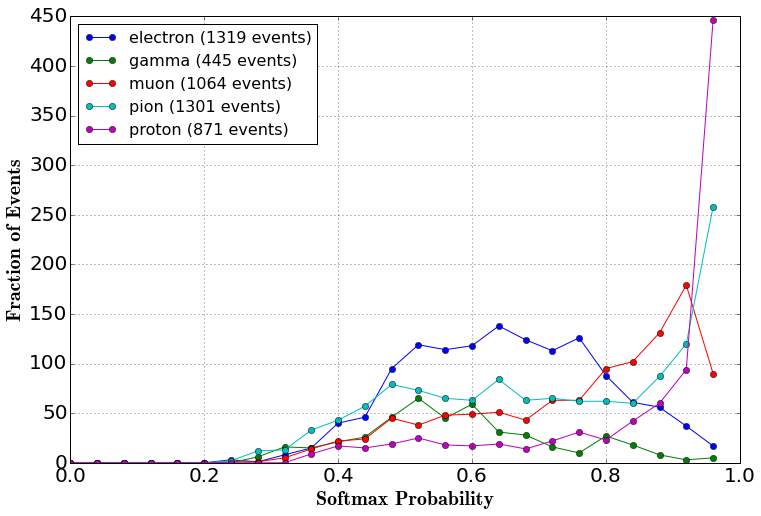

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

particles = ['electron','gamma','muon','pion','proton']

fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
for index, particle in enumerate(particles):
    # Query subset of data predicted to be "this" particle
    sub_df = df.query('prediction==%d' % index)
    # Make a binned distribution (and scatter-plot it since 5 histogram overlay is hard to see)
    hist, _ = np.histogram(sub_df.probability.values, bins=25, range=(0.,1.))
    # Plot
    label = '%s (%d events)' % (particle,sub_df.index.size)
    plt.plot(np.arange(0.,1.,1./25.),hist, label=label, marker='o')
    # Decoration!
    plt.tick_params(labelsize=20)
    plt.xlabel('Softmax Probability',fontsize=20,fontweight='bold',fontname='Georgia')
    plt.ylabel('Fraction of Events',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=2)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.grid()
plt.show()

It shows that the network has _high confidence_ when it's predicitng a proton but not quite certain when it comes to conclude electron or gamma. Probably pion is also having a hard time though it is hard to even see it here. 

We can study more about our network's performance if we have _truth_ information (i.e. label). Luckily we are not working on the _challenge data_ but just _test data_ which contains truth information. So let's store the truth label to project onto the correct label.

## Inference 2
All we want is to store additional variable in the csv file. But let's just do the loop one more time because it is instructive though it's slow. Take this opportunity to learn how to set the file reader to read a specific entry.

In [15]:
# First we need to purge the storage buffer
test_io.stop_manager()    # stop running threads
test_io.purge_storage()   # remove all data stored in buffer (since we'll re-read)
test_io.set_next_index(0) # explicitly set the next read happens @ index=0 (first event)

# Now run threaded read again
test_io.start_manager(BATCH_SIZE)
test_io.next(store_entries=True,store_event_ids=True)

Let's run the loop again! We'll create a separate csv file.

In [16]:
csv_filename = 'tutorial06-classification-inference2.csv'
fout=open(csv_filename,'w')
fout.write('entry,run,subrun,event,prediction,prediction_probability,label,label_probability\n')
ctr = 0
num_events = test_io.fetch_n_entries()
while ctr < num_events:

    test_data  = test_io.fetch_data('test_image').data()
    test_label = test_io.fetch_data('test_label').data()
    feed_dict = { data_tensor  : test_data }

    softmax_batch     = sess.run(softmax_op, feed_dict=feed_dict)
    processed_events  = test_io.fetch_event_ids()
    processed_entries = test_io.fetch_entries()

    for j in xrange(len(softmax_batch)):
        softmax_array = softmax_batch[j]
        entry         = processed_entries[j]
        event_id      = processed_events[j]
        
        prediction      = np.argmax(softmax_array)
        prediction_prob = softmax_array[prediction]
        label           = np.argmax(test_label[j])
        label_prob      = softmax_array[label]
        
        data_string = '%d,%d,%d,%d,%d,%g,%d,%g\n' % (entry, 
                                                     event_id.run(), event_id.subrun(), event_id.event(),
                                                     prediction, prediction_prob,
                                                     label,label_prob)
        fout.write(data_string)

        ctr += 1
        if ctr == num_events:
            break
    if ctr == num_events:
        break

    test_io.next(store_entries=True,store_event_ids=True)
    
fout.close()

This time, we will group events by its truth label and plot the label's softmax probability:

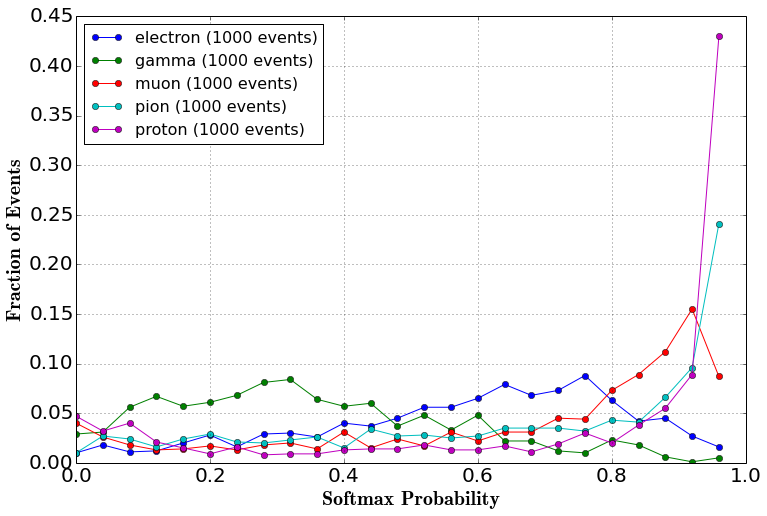

In [17]:
df = pd.read_csv(csv_filename)
particles = ['electron','gamma','muon','pion','proton']

fig,ax = plt.subplots(figsize=(12,8),facecolor='w')
for index, particle in enumerate(particles):
    # Query subset of data predicted to be "this" particle
    sub_df = df.query('label==%d' % index)

    # Make a binned distribution (and scatter-plot it since 5 histogram overlay is hard to see)
    hist, _ = np.histogram(sub_df.label_probability.values, 
                           bins=25, range=(0.,1.), 
                           weights=[1./sub_df.index.size] * sub_df.index.size)
    # Plot
    label = '%s (%d events)' % (particle,sub_df.index.size)
    plt.plot(np.arange(0.,1.,1./25.), hist, label=label, marker='o')
    # Decoration!
    plt.tick_params(labelsize=20)
    plt.xlabel('Softmax Probability',fontsize=20,fontweight='bold',fontname='Georgia')
    plt.ylabel('Fraction of Events',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=16,loc=2)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.grid()
plt.show()

This plot is somewhat similar to the one we plotted earlier using prediction softmax probability. Probably the most notable is that blue (electron) and green (gamma) got worse (i.e. peak moved toward left and/or peak smeared). Is a network doing somewhat random guess on them? Possibly for gamma, maybe better than random for electron.

But thinking from physics perspective, we realize that electron and gamma share great similarity: they are both _EM-shower_ particles. This means their geometrical shapes are quite alike, and are easily distinguishable from the rest of partciles (i.e. none-EM-shower, or _track_ particles). Having the ground-truth allows us to check on this assumption.

In [19]:
# Query EM-Shower (electron or gamma ray) particles
emshower = df.query('label in [0,1]').index.size
# Count how many of them were selected right
emshower_correct = df.query('label in [0,1] and prediction in [0,1]').index.size
print('EM-Shower correct fraction:',emshower_correct,'/',emshower,'=',float(emshower_correct)/emshower*100.,'[%]')


# Repeat for track (i.e. non-EM-shower) particles
track = df.query('label not in [0,1]').index.size
# Count how many of them were selected right
track_correct = df.query('label not in [0,1] and prediction not in [0,1]').index.size
print('Track correct fraction:',track_correct,'/',track,'=',float(track_correct)/track*100.,'[%]')

EM-Shower correct fraction: 1722 / 2000 = 86.1 [%]
Track correct fraction: 2958 / 3000 = 98.6 [%]


... so indeed the trained network seems to distinguish two set of geometrical shapes (i.e. EM-shower and track particles) quite well. At the same time, this means the network is having very hard time distinguishing electron from gamma and vice versa.

Coming back to the main point, in this notebook we exercised how to run a simple inference using `larcv_threadio`. So what is _not simple_ inference? In the next tutorial, we go over how to store the output into larcv format data file in the case of running a _semantic segmentation network_ or SSNet. In this example the "output" from the network was just an array of floats (i.e. softmax probability). But in the case of SSNet, the output is essentially an image with many channels, which can be stored just like input image into a larcv file.